In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import json

In [40]:
# helper function for data visualization
from skimage import color

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [41]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [46]:
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import time
import torch.nn.functional as F
import torch

class SkinDataset(Dataset):
    def __init__(self, df_file, augmentation=None, 
            preprocessing=None):
        super().__init__()
        self.data = pd.read_csv(df_file)
        #self.data = json.load(open('data/training_clean_dataset.json'))
        self.label_names = ['B']+list(self.data['lesions'].unique())
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        image = Image.open(self.data.loc[idx,'image_full_path'])
        mask = self.get_mask_pil_image(idx, image)
        mask = np.array(mask)
        image = np.array(image)
        # extract certain classes from mask
        # masks = [(mask == v) for v in range(len(self.label_names))]
        # mask = np.stack(masks, axis=-1).astype('float')
         # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.data.index)
    
    def get_mask_pil_image(self, idx, image):
        item = json.loads(self.data.loc[idx,'annotations'].replace("\'", "\""))
        polygons = []
        for ann in item:
            if "polygon" in ann:
                loc = ann['polygon']['location'][0]
                points = []
                for point_num in range(1, len(loc.keys())//2+1):
                    points.append([loc[f'x{point_num}'], loc[f'y{point_num}']])
                polygons.append(np.array(points))
        mask = np.zeros((image.size[1], image.size[0]))
        cv2.fillPoly(mask, polygons, self.label_names.index(self.data.loc[idx, 'lesions']))
        mask = mask.astype(np.uint8)
        im = Image.fromarray(mask)
        return im

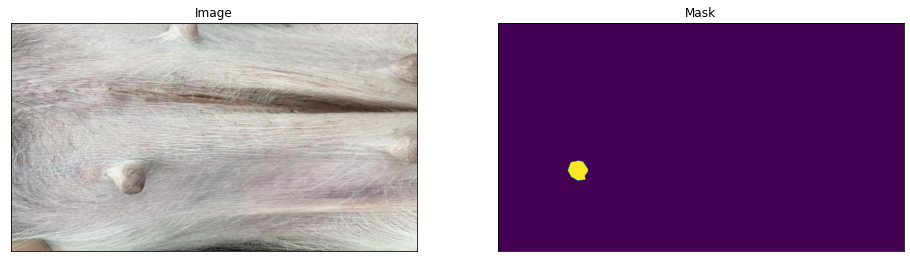

In [47]:
dataset = SkinDataset('data/training_clean_dataset.csv')

image, mask = dataset[500]
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [52]:
import albumentations as albu
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

#         albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.LongestMaxSize(512, always_apply=True),

        albu.GaussNoise(p=0.2),
        #albu.Perspective (p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen (p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

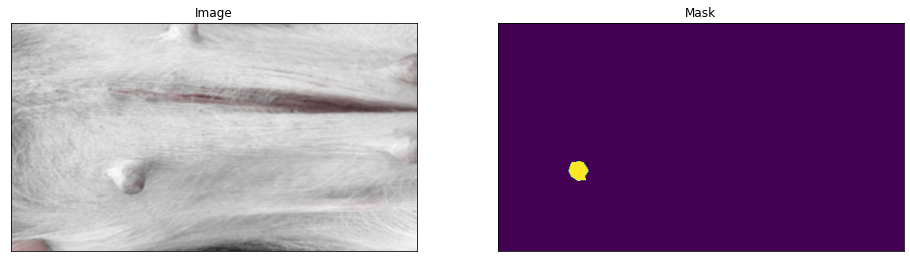

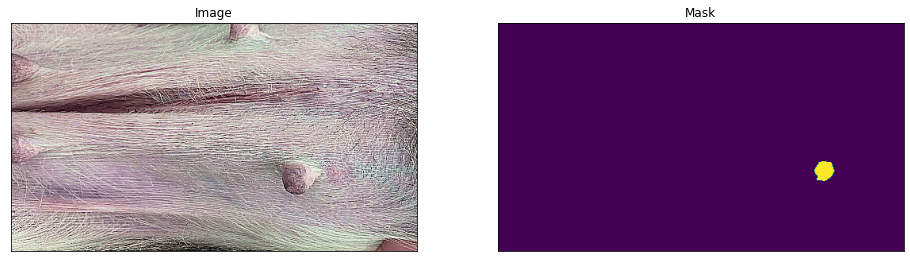

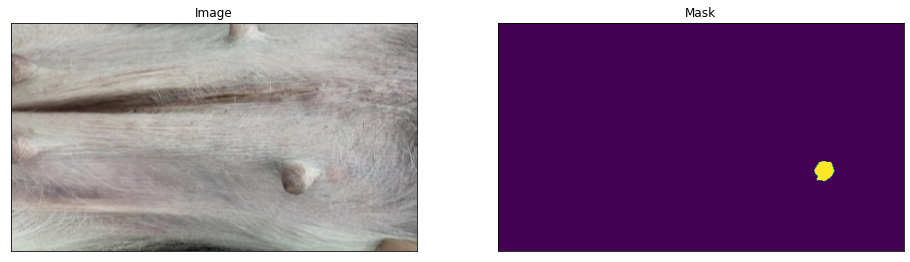

In [53]:
#### Visualize resulted augmented images and masks

augmented_dataset = SkinDataset('data/training_clean_dataset.csv',
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[500]
    visualize(image=image, mask=mask)

## Create model and train

In [54]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils
from tqdm.notebook import trange, tqdm


In [55]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = dataset.label_names
ACTIVATION = None # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [56]:
train_num = int(len(augmented_dataset)*0.8)
val_num = len(augmented_dataset) - train_num
train_dataset, val_dataset = torch.utils.data.random_split(augmented_dataset, [train_num, val_num], generator=torch.Generator().manual_seed(42))
small_train_dataset = torch.utils.data.Subset(train_dataset, range(100))
small_val_dataset = torch.utils.data.Subset(val_dataset, range(100))

train_loader = DataLoader(small_train_dataset, batch_size=8, shuffle=True, num_workers=1)
valid_loader = DataLoader(small_val_dataset, batch_size=1, shuffle=False)

In [58]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [59]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [36]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
train:   0%|          | 0/13 [00:00<?, ?it/s]